# Randomization analysis

In this notebook we investigate whether interactions with an unbalance of simple and twisted read pairs occur more often than expected by chance. Similar to the FDR procedure, we randomize the simple and twisted read pair counts in each interaction according to a binomial distribution with $p=0.5$ and then determine the total number of significant interactions at a given nominal alpha. But instead of doing only one iteration of this procedure, as we do for estimating the FDR, we do many interations, e.g. ``10,000``. If we never observe more significant interactions than for the non-randomized data, we speak of an empirical P-value of ``1/10000``. In addition, we calculate the mean and standard devaition for the numbers of randomized significant interactions from all iterations, and from this, in turn, a Z-score.

## Setting up the notebook

In [1]:
import sys
import os
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes and functions:
* ``DiachromaticInteractionSet``
    - ``parse_file``: Read interactions from file
    - ``get_read_file_info_report``: Get information about files that have already been read in form of a formatted string
* ``RandomizeInteractionSet``
    - ``perform_randomization_analysis``: The entire randomzation analysis is carried out in this function using sub-functions that are also used for the FDR procedure, which is also implemented in ``RandomizeInteractionSet``

We use the ``DiachromaticInteractionSet`` to read interactions from a file. The FDR procedure is carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

We use the test file with ``64,000`` interactions, which we also use to test the FDR procedure.

In [2]:
ls ../tests/data/test_03/*top_64000*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz


## Demonstration of the analysis using the test file with ``64,000`` interactions

First, we read the interaction file into an interaction set.

In [3]:
interaction_set = DiachromaticInteractionSet()
interaction_set.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz', verbose=True)
read_file_info_report = interaction_set.get_read_file_info_report()
print(read_file_info_report)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
[INFO] ... done.
[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 64,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
			[INFO] Set size: 64,000
	[INFO] The interaction set has 64,000 interactions.
[INFO] End of report.



Next, we create an object of class ``RandomizeInteractionSet`` and pass the interaction set to this object.

In [4]:
randomization_analysis = RandomizeInteractionSet(interaction_set=interaction_set)

Then we call the function ``perform_randomization_analysis`` of the class ``RandomizeInteractionSet`` in which the entire randomization analysis is implemented. To this function, a ``nominal_alpha`` is passed, which is used as the P-value threshold. Interactions that have a smaller P-value are counted as significant.

In addition, the number of iterations can be specified (``thread_num`` defaults to ``1,000``).

Dependinng on the number of innput interactions and iterations, the analysis can be computational intensive.

Therefore, batches of iterations can be carried out in paralell.

If ``thread_num=0`` (default), the Python package ``multiprocessing`` is not used and all iterations are performed in sequence.

If ``thread_num=1``, 

In [8]:
import time
start = time.time()
randomization_analysis_info_dict = randomization_analysis.perform_randomization_analysis(
    nominal_alpha = 0.00325,
    iter_num = 110,
    thread_num=3,
    verbose = True)
end = time.time()
print("\nRuntime: " + str(end-start) + '\n')
print(randomization_analysis.get_randomization_info_report())

[INFO] Performing randomization analysis with 110 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Batch: Performing 38 iterations ...
			[INFO] First iteration indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,...
		[INFO] Batch: Performing 36 iterations ...
			[INFO] First iteration indices: [38, 39, 40, 41, 42, 43, 44, 45, 46, 47 ,...
		[INFO] Batch: Performing 36 iterations ...
			[INFO] First iteration indices: [74, 75, 76, 77, 78, 79, 80, 81, 82, 83 ,...
	[INFO] Calculating summary statistics ...
[INFO] ... done.

Runtime: 10.36952519416809

[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Nominal alpha: 0.00325
		[INFO] Number of iterations: 110
		[INFO] Number of input interactions: 64,000
	[INFO] Results:
		[INFO] Original number of significant interactions: 1,512
		[INFO] First 10 significant randomized interaction numbers: 
			[69, 69, 57, 67, 60, 68, 49, 62, 60, 68 ,...


In [6]:
pandas.DataFrame(randomization_analysis_info_dict['RESULTS']['SUMMARY'])

,SIG_NUM_O,SIG_NUM_R_MEAN,SIG_NUM_R_STD,Z_SCORE
0,1512,61.545455,7.328198,197.927872


Text(439.54545454545456, 900, 'Z-score: 197.93')

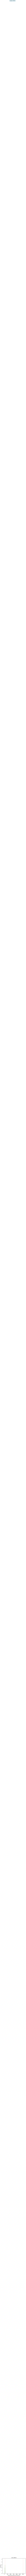

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

x = randomization_analysis_info_dict['RESULTS']['SIG_NUM_R_LIST']
sig_num_o = randomization_analysis_info_dict['RESULTS']['SUMMARY']['SIG_NUM_O'][0]
sig_num_r_mean = randomization_analysis_info_dict['RESULTS']['SUMMARY']['SIG_NUM_R_MEAN'][0]
z_score = float(randomization_analysis_info_dict['RESULTS']['SUMMARY']['Z_SCORE'][0])

n, bins, patches = plt.hist(x, 5, density=False, facecolor='g', alpha=0.75)
plt.xlim(min(x) - 200, sig_num_o + 200)

plt.title('OUT_PREFIX')
plt.xlabel('Randomized significant interactions')
plt.ylabel('Iterations')
plt.axvline(sig_num_r_mean, linestyle='--', color='red', linewidth=0.5)
plt.axvline(sig_num_o, linestyle='--', color='red', linewidth=0.5)


plt.text(sig_num_r_mean + sig_num_o/4, 900,'Z-score: ' + "{:.2f}".format(z_score), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})

